#### Packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#### Plots

In [2]:
def plot_training(path):

    epochs = []
    nlls = []

    with open(path, 'r') as file:
        for line in file:
            if line.startswith('epoch:'):
                # Split the line and extract epoch and nll values
                parts = line.split()
                epochs.append(int(parts[1]))
                nlls.append(float(parts[3]))

    # Create the plot
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, nlls)
    plt.title('Training Progress: Negative Log-Likelihood (NLL)')
    plt.xlabel('Epoch')
    plt.ylabel('Negative Log-Likelihood')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#### Target LSTM

In [3]:
class TargetLSTM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, sequence_length, start_token, device='cpu'):
        
        super(TargetLSTM, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length
        self.start_token = start_token
        self.device = device
        
        # Define layers
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)
        
        # Initialize on device
        self.to(device)
       
    def forward(self, x, hidden=None):

        emb = self.embeddings(x)                    # [batch_size, sequence_length, embedding_dim]
        lstm_out, hidden = self.lstm(emb, hidden)   # lstm_out: [batch_size, sequence_length, hidden_dim]
        logits = self.output_layer(lstm_out)        # [batch_size, sequence_length, vocab_size]
        
        return logits, hidden
    
    def generate(self, num_samples):

        with torch.no_grad():
            
            # Start token for all sequences
            x = torch.full((num_samples, 1), self.start_token, dtype=torch.long, device=self.device)
            hidden = None  # Let PyTorch initialize the hidden state

            generated_sequences = torch.zeros(num_samples, self.sequence_length, dtype=torch.long, device=self.device)

            for i in range(self.sequence_length):
                # Forward pass
                emb = self.embeddings(x[:, -1:])  # Only use the last token
                lstm_out, hidden = self.lstm(emb, hidden)
                logits = self.output_layer(lstm_out)
                
                # Sample from distribution
                probs = F.softmax(logits.squeeze(1), dim=-1)
                next_token = torch.multinomial(probs, 1)
                
                # Add to sequence
                generated_sequences[:, i] = next_token.squeeze()
                
                # Update input for next step (only need the current token, not the entire history)
                x = next_token
            
            return generated_sequences

    def calculate_nll(self, generated_sequences):

        with torch.no_grad():
            # Use all tokens except the last one as input
            inputs = generated_sequences[:, :-1]
            
            # Use all tokens except the first one as targets
            targets = generated_sequences[:, 1:]
            
            # Forward pass
            logits, _ = self.forward(inputs)
            
            # Calculate negative log-likelihood
            nll = F.cross_entropy(logits.reshape(-1, self.vocab_size), targets.reshape(-1), reduction='mean')
            
            return nll.item()

    def load_params(self, params_path):
        """
        Load parameters from a TensorFlow list format.
        """
        try:
            with open(params_path, 'rb') as f:
                try:
                    params = pickle.load(f)
                except UnicodeDecodeError:
                    f.seek(0)
                    params = pickle.load(f, encoding='latin1')
        except Exception as e:
            print(f"Error loading pickle file: {str(e)}")
            return self
        
        with torch.no_grad():
            # 1. Embeddings
            self.embeddings.weight.copy_(torch.tensor(params[0], dtype=torch.float32))
            
            # 2. LSTM Parameters
            # Extract individual LSTM weights
            Wi, Ui, bi = params[1], params[2], params[3]  # Input gate
            Wf, Uf, bf = params[4], params[5], params[6]  # Forget gate
            Wo, Uo, bo = params[7], params[8], params[9]  # Output gate
            Wc, Uc, bc = params[10], params[11], params[12]  # Cell state
            
            # Concatenate the weights in PyTorch's expected format
            weight_ih = np.vstack([Wi, Wf, Wc, Wo])
            weight_hh = np.vstack([Ui, Uf, Uc, Uo])
            
            # Bias is also concatenated
            bias_ih = np.concatenate([bi, bf, bc, bo])
            bias_hh = np.zeros_like(bias_ih)
            
            # Copy to PyTorch model
            self.lstm.weight_ih_l0.copy_(torch.tensor(weight_ih, dtype=torch.float32))
            self.lstm.weight_hh_l0.copy_(torch.tensor(weight_hh, dtype=torch.float32))
            self.lstm.bias_ih_l0.copy_(torch.tensor(bias_ih, dtype=torch.float32))
            self.lstm.bias_hh_l0.copy_(torch.tensor(bias_hh, dtype=torch.float32))
            
            # 3. Output layer
            self.output_layer.weight.copy_(torch.tensor(params[13].T, dtype=torch.float32))
            self.output_layer.bias.copy_(torch.tensor(params[14], dtype=torch.float32))
        
        return self

    def save_params(self, path):
        torch.save(self.state_dict(), path)
        
    def save_samples(self, samples, file_path):
        with open(file_path, 'w') as f:
            for sample in samples.cpu().numpy():
                f.write(' '.join([str(int(x)) for x in sample]) + '\n')



#### Generator

In [ ]:
class Generator(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, sequence_length, start_token, device='cpu'):
        
        super(Generator, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length
        self.start_token = start_token
        self.device = device
        
        # Define layers
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)
                
        # Initialize on device
        self.to(device)
       
    def forward(self, x, hidden=None):

        emb = self.embeddings(x)                    # [batch_size, sequence_length, embedding_dim]
        lstm_out, hidden = self.lstm(emb, hidden)   # lstm_out: [batch_size, sequence_length, hidden_dim]
        logits = self.output_layer(lstm_out)        # [batch_size, sequence_length, vocab_size]
        
        return logits, hidden
    
    def generate(self, num_samples):

        with torch.no_grad():
            
            # Start token for all sequences
            x = torch.full((num_samples, 1), self.start_token, dtype=torch.long, device=self.device)
            hidden = None  # Let PyTorch initialize the hidden state

            generated_sequences = torch.zeros(num_samples, self.sequence_length, dtype=torch.long, device=self.device)

            for i in range(self.sequence_length):
                # Forward pass
                emb = self.embeddings(x[:, -1:])  # Only use the last token
                lstm_out, hidden = self.lstm(emb, hidden)
                logits = self.output_layer(lstm_out)
                
                # Sample from distribution
                probs = F.softmax(logits.squeeze(1), dim=-1)
                next_token = torch.multinomial(probs, 1)
                
                # Add to sequence
                generated_sequences[:, i] = next_token.squeeze()
                
                # Update input for next step (only need the current token, not the entire history)
                x = next_token
            
            return generated_sequences
        
    def save_params(self, path):
        torch.save(self.state_dict(), path)

    def pretrain_step(self, x, optimizer):

        optimizer.zero_grad()
            
        inputs = x[:, :-1]                  # Forward pass - input is all tokens except last one
        targets = x[:, 1:].contiguous()     # Target is all tokens except first one (shifted by 1)
        
        logits, _ = self.forward(inputs)
    
        loss = F.cross_entropy(logits.reshape(-1, self.vocab_size), targets.reshape(-1))
        
        loss.backward()
        optimizer.step()
        
        return loss.item()

def pretrain_generator(target_lstm, generator, optimizer, pre_epoch_num, batch_size, generated_num, eval_freq, lr_patience, lr_decay):
    
    print('Start pre-training...')

    # Open log file
    log = open('NEW_experiment-log.txt', 'w')
    log.write('pre-training...\n')

    # For learning rate scheduling
    best_loss = float('inf')
    patience_counter = 0
        
    
    # Generate Oracle Data
    target_lstm.eval()
    oracle_data = target_lstm.generate(generated_num)
    
    # Create DataLoader
    oracle_dataset = torch.utils.data.TensorDataset(oracle_data)
    oracle_loader = torch.utils.data.DataLoader(
        oracle_dataset, 
        batch_size=batch_size,
        shuffle=True
    )
    
    # Training loop
    for epoch in range(pre_epoch_num):

        epoch_loss = 0
        batch_count = 0

        # Evaluate using the oracle every eval_freq epochs
        if epoch % eval_freq == 0 or epoch == pre_epoch_num - 1:

            generated_samples = generator.generate(int(generated_num/10))
            
            # Calculate NLL using the oracle
            nll = target_lstm.calculate_nll(generated_samples)
            print(f'Epoch {epoch}, NLL: {nll:.4f}')

            # Log to file
            buffer = f'epoch:\t{epoch}\tnll:\t{nll:.5f}\n'
            log.write(buffer)
            log.flush()  # Ensure it's written immediately
        
        # Train on all batches
        for batch_data in oracle_loader:
            x = batch_data[0]
            loss = generator.pretrain_step(x, optimizer)
            epoch_loss += loss
            batch_count += 1
        
        # Calculate average loss for this epoch
        avg_loss = epoch_loss / batch_count
        #print(f'Epoch {epoch}, Average Loss: {avg_loss:.4f}')

        # Learning rate scheduling
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= lr_patience:
            # Reduce learning rate
            for param_group in optimizer.param_groups:
                param_group['lr'] *= lr_decay
            print(f"Learning rate reduced to {optimizer.param_groups[0]['lr']}")
            patience_counter = 0

    log.close()    
    print('Pretraining finished!')
    


#### Pretraining

In [5]:
# Initialize models
VOCAB_SIZE = 5000
EMB_DIM = 32 
HIDDEN_DIM = 32 
SEQ_LENGTH = 20 
START_TOKEN = 0
PRE_EPOCH_NUM = 250
BATCH_SIZE = 64
SEED = 88
set_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generated_num = 10000

# Create models
target_lstm = TargetLSTM(VOCAB_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN, device)
target_lstm.load_params(params_path='save/target_params_py3.pkl')
generator = Generator(VOCAB_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN, device)

# Initialize optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.01)

# PRETRAINING
pretrain_generator(target_lstm, generator, g_optimizer, PRE_EPOCH_NUM, BATCH_SIZE, generated_num, eval_freq=5, lr_patience=5, lr_decay=0.5)


Start pre-training...
Epoch 0, NLL: 11.4067
Epoch 5, NLL: 9.8362
Epoch 10, NLL: 9.5356
Epoch 15, NLL: 9.4628
Epoch 20, NLL: 9.4149
Epoch 25, NLL: 9.4071
Epoch 30, NLL: 9.3488
Epoch 35, NLL: 9.4076
Epoch 40, NLL: 9.3776
Epoch 45, NLL: 9.3813
Epoch 50, NLL: 9.4371
Epoch 55, NLL: 9.3916
Epoch 60, NLL: 9.4746
Epoch 65, NLL: 9.4136
Epoch 70, NLL: 9.4187
Epoch 75, NLL: 9.4182
Learning rate reduced to 0.005
Epoch 80, NLL: 9.3934
Epoch 85, NLL: 9.3901
Epoch 90, NLL: 9.3422
Epoch 95, NLL: 9.3473
Epoch 100, NLL: 9.3367
Epoch 105, NLL: 9.3802
Epoch 110, NLL: 9.4147
Epoch 115, NLL: 9.3509
Epoch 120, NLL: 9.3354
Epoch 125, NLL: 9.3735
Epoch 130, NLL: 9.3762
Learning rate reduced to 0.0025
Epoch 135, NLL: 9.3860
Epoch 140, NLL: 9.3476
Epoch 145, NLL: 9.3365
Epoch 150, NLL: 9.3442
Epoch 155, NLL: 9.3464
Epoch 160, NLL: 9.3638
Learning rate reduced to 0.00125
Epoch 165, NLL: 9.3927
Epoch 170, NLL: 9.3569
Epoch 175, NLL: 9.3782
Epoch 180, NLL: 9.3548
Epoch 185, NLL: 9.3698
Epoch 190, NLL: 9.3704
Epoch 

In [6]:
generator_final = generator.generate(10000)
print(target_lstm.calculate_nll(generated_sequences=generator_final))

9.36923599243164


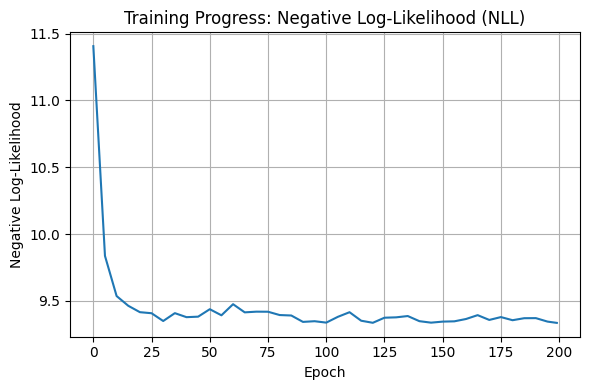

In [7]:
plot_training('NEW_experiment-log.txt')

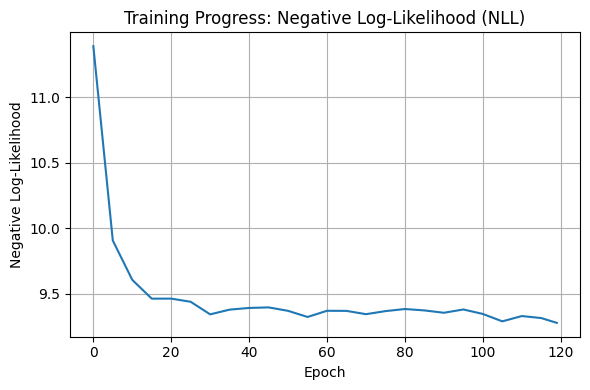

In [18]:
plot_training('NEW_experiment-log.txt')

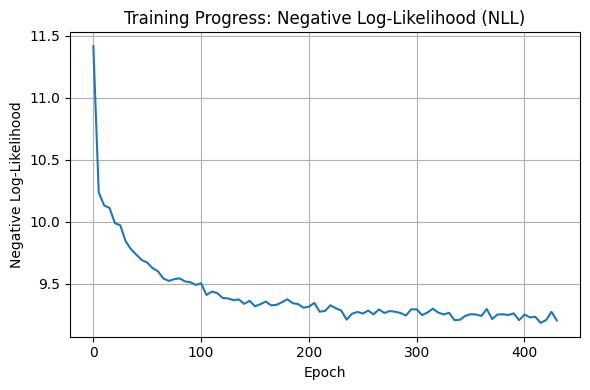

In [6]:
plot_training('NEW_experiment-log.txt')

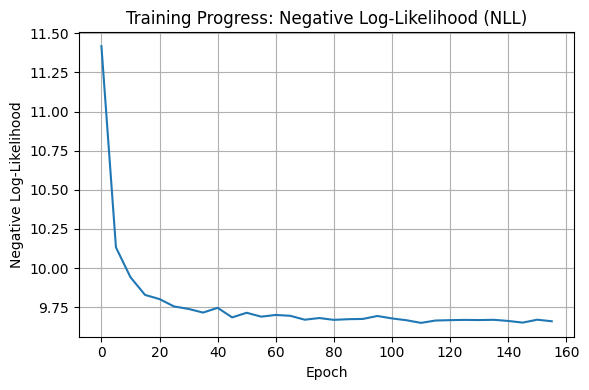

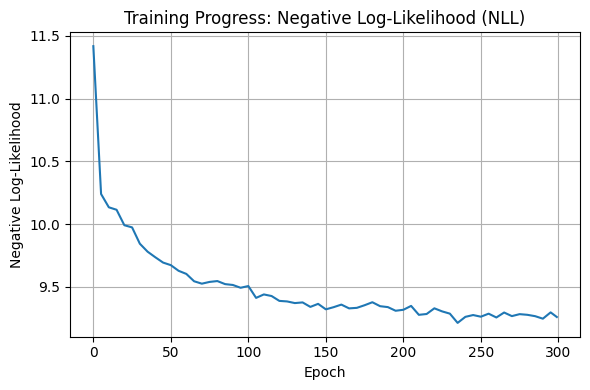

In [11]:
plot_training('NEW_experiment-log.txt')

#### Discriminator

In [ ]:
class Highway(nn.Module):

    def __init__(self, size, bias=-2.0):        # Initialize gate bias to negative value to start with 
        
        super(Highway, self).__init__()
        self.transform_gate = nn.Linear(size, size)
        self.highway_layer = nn.Linear(size, size)
        nn.init.constant_(self.transform_gate.bias, bias)
        
    def forward(self, x):
        
        transform_gate = torch.sigmoid(self.transform_gate(x))
        highway_layer_output = F.relu(self.highway_layer(x))
        
        return transform_gate * highway_layer_output + (1 - transform_gate) * x


class Discriminator(nn.Module):

    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 filter_sizes, 
                 num_filters, 
                 sequence_length, 
                 dropout_prob=0.5,
                 highway_layers=1,
                 l2_reg_lambda=0.0,
                 device='cpu'):

        super(Discriminator, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.filter_sizes = filter_sizes
        self.num_filters = num_filters
        self.sequence_length = sequence_length
        self.dropout_prob = dropout_prob
        self.l2_reg_lambda = l2_reg_lambda
        self.device = device
        
        # Word embeddings
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # Convolutional layers
        self.convs = nn.ModuleList([
            nn.Conv2d(
                in_channels=1, 
                out_channels=num_filters[i], 
                kernel_size=(filter_size, embedding_dim), 
                stride=1
            ) for i, filter_size in enumerate(filter_sizes)
        ])
        
        
        self.num_filters_total = sum(num_filters)                                                                   # Total number of filters across all filter sizes
        self.highway = Highway(self.num_filters_total)                                                              # Highway layer
        self.highway_layers = nn.ModuleList([Highway(self.num_filters_total) for _ in range(highway_layers-1)])     # Highway layer can be repeated
        self.dropout = nn.Dropout(dropout_prob)                                                                     # Dropout layer
        self.output_layer = nn.Linear(self.num_filters_total, 1)                                                    # Output layer
        
        self._init_weights()                                                                                        # Initialize all weights
        self.to(device)                                                                                             # Move to device
    
    def _init_weights(self):

        for conv in self.convs:
            nn.init.xavier_uniform_(conv.weight)
            nn.init.constant_(conv.bias, 0.1)
        
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.constant_(self.output_layer.bias, 0.1)
    
    def forward(self, x):

        embedded = self.embeddings(x)           # [batch_size, sequence_length, embedding_dim]
        embedded = embedded.unsqueeze(1)        # Add channel dim for CNN: [batch_size, 1, sequence_length, embedding_dim]
        
        pooled_outputs = []
        for i, conv in enumerate(self.convs):
            # Conv layer
            conv_out = F.relu(conv(embedded))  # [batch_size, num_filters[i], sequence_length - filter_sizes[i] + 1, 1]
            
            # Max-pooling
            pool_out = F.max_pool2d(
                conv_out, 
                kernel_size=(conv_out.size(2), 1)
            )  # [batch_size, num_filters[i], 1, 1]
            
            pooled_outputs.append(pool_out)
        
        # Concatenate all pooled features
        pooled_concat = torch.cat(pooled_outputs, dim=1)  # [batch_size, num_filters_total, 1, 1]
        pooled_flat = pooled_concat.view(-1, self.num_filters_total)  # [batch_size, num_filters_total]
        
        # Highway network
        highway_out = self.highway(pooled_flat)
        for highway_layer in self.highway_layers:
            highway_out = highway_layer(highway_out)
        
        # Dropout
        dropped = self.dropout(highway_out)
        
        # Output layer
        logits = self.output_layer(dropped)  # [batch_size, 1]
        predictions = torch.sigmoid(logits).squeeze()  # [batch_size]
        
        return predictions
    
    def train_step(self, real_data, fake_data, optimizer):
        """
        Train the discriminator for one step
        
        Args:
            real_data: Real sequences [batch_size, sequence_length]
            fake_data: Generated sequences [batch_size, sequence_length]
            optimizer: Optimizer for updating weights
            
        Returns:
            loss: Training loss for this step
        """
        optimizer.zero_grad()
        
        # Create labels: 1 for real, 0 for fake
        real_labels = torch.ones(real_data.size(0), device=self.device)
        fake_labels = torch.zeros(fake_data.size(0), device=self.device)
        
        # Forward pass for real data
        real_pred = self.forward(real_data)
        real_loss = F.binary_cross_entropy(real_pred, real_labels)
        
        # Forward pass for fake data
        fake_pred = self.forward(fake_data)
        fake_loss = F.binary_cross_entropy(fake_pred, fake_labels)
        
        # Combined loss
        loss = real_loss + fake_loss
        
        # Add L2 regularization if specified
        if self.l2_reg_lambda > 0:
            l2_reg = 0.0
            for param in self.parameters():
                l2_reg += torch.norm(param, 2)
            loss += self.l2_reg_lambda * l2_reg
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        return loss.item()

def evaluate_discriminator(discriminator, target_lstm, generator, num_samples, device='cpu'):

    discriminator.eval()
    target_lstm.eval()
    generator.eval()
    
    with torch.no_grad():
        # Generate data
        real_data = target_lstm.generate(num_samples)
        fake_data = generator.generate(num_samples)
        
        # Get predictions
        real_preds = discriminator(real_data)
        fake_preds = discriminator(fake_data)
        
        # Calculate metrics
        real_correct = (real_preds >= 0.5).sum().item()
        fake_correct = (fake_preds < 0.5).sum().item()
        
        accuracy = (real_correct + fake_correct) / (2 * num_samples)
        real_prob = real_preds.mean().item()
        fake_prob = fake_preds.mean().item()
    
    metrics = {
        'accuracy': accuracy,
        'real_prob': real_prob,
        'fake_prob': fake_prob
    }
    
    return metrics




CHECK YOU ALREADY HAVE THE TRAIN STEP OF THE DISCRIMINATOR. And why do the use the real data once for all epochs?

In [ ]:
def pretrain_discriminator(target_lstm, generator, discriminator, optimizer, epochs, batch_size, generated_num, eval_freq=1, lr_patience=3, lr_decay=0.5, log_file='disc_pretrain.txt', device='cpu'):

    print('Start pre-training discriminator...')
    
    # For learning rate scheduling
    best_accuracy = 0.0
    patience_counter = 0
    
    # Training history for plotting
    history = {
        'loss': [],
        'accuracy': [],
        'real_probs': [],
        'fake_probs': []
    }
    
    # Create log file
    log = open(log_file, 'w')
    log.write('pre-training...\n')
    
    # Generate real data from oracle
    target_lstm.eval()
    real_data = target_lstm.generate(generated_num)
    
    # Generate fake data for initial evaluation
    generator.eval()
    with torch.no_grad():
        fake_data = generator.generate(generated_num)
    
    # Initial evaluation (epoch 0, before training)
    initial_metrics = evaluate_discriminator(discriminator, target_lstm, generator, num_samples=1000, device=device)
    print(f'Epoch 0 (Before Training), Accuracy: {initial_metrics["accuracy"]:.4f}')
    print(f'Real probs: {initial_metrics["real_prob"]:.4f}, Fake probs: {initial_metrics["fake_prob"]:.4f}')
    
    # Log initial metrics
    log.write(f'epoch:\t0\tacc:\t{initial_metrics["accuracy"]:.6f}\treal_prob:\t{initial_metrics["real_prob"]:.6f}\tfake_prob:\t{initial_metrics["fake_prob"]:.6f}\n')
    
    # Add initial metrics to history
    history['accuracy'].append(initial_metrics['accuracy'])
    history['real_probs'].append(initial_metrics['real_prob'])
    history['fake_probs'].append(initial_metrics['fake_prob'])
    # Add a placeholder for loss at epoch 0
    history['loss'].append(0.0)
    
    # Training loop
    for epoch in range(1, epochs + 1):  # Start from 1 since we've already done epoch 0 evaluation
        # Set models to appropriate modes
        generator.eval()
        discriminator.train()
        
        # Generate fake data
        with torch.no_grad():
            fake_data = generator.generate(generated_num)
        
        # Create DataLoaders
        real_dataset = torch.utils.data.TensorDataset(real_data)
        fake_dataset = torch.utils.data.TensorDataset(fake_data)
        
        real_loader = torch.utils.data.DataLoader(
            real_dataset, batch_size=batch_size, shuffle=True
        )
        
        fake_loader = torch.utils.data.DataLoader(
            fake_dataset, batch_size=batch_size, shuffle=True
        )
        
        # Training metrics for this epoch
        epoch_loss = 0
        num_batches = min(len(real_loader), len(fake_loader))
        
        # Train on batches
        for (real_batch,), (fake_batch,) in zip(real_loader, fake_loader):
            real_batch = real_batch.to(device)
            fake_batch = fake_batch.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass for real data
            real_pred = discriminator(real_batch)
            real_labels = torch.ones(real_batch.size(0), device=device)
            real_loss = torch.nn.functional.binary_cross_entropy(real_pred, real_labels)
            
            # Forward pass for fake data
            fake_pred = discriminator(fake_batch)
            fake_labels = torch.zeros(fake_batch.size(0), device=device)
            fake_loss = torch.nn.functional.binary_cross_entropy(fake_pred, fake_labels)
            
            # Combined loss
            loss = real_loss + fake_loss
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            # Update loss
            epoch_loss += loss.item()
        
        # Calculate average loss
        avg_loss = epoch_loss / num_batches
        
        # Evaluate the discriminator
        metrics = evaluate_discriminator(discriminator, target_lstm, generator, num_samples=1000, device=device)
        
        # Update history with metrics (for plotting)
        history['loss'].append(avg_loss)
        history['accuracy'].append(metrics['accuracy'])
        history['real_probs'].append(metrics['real_prob'])
        history['fake_probs'].append(metrics['fake_prob'])
        
        # Log metrics to file
        log.write(f'epoch:\t{epoch}\tloss:\t{avg_loss:.6f}\tacc:\t{metrics["accuracy"]:.6f}\treal_prob:\t{metrics["real_prob"]:.6f}\tfake_prob:\t{metrics["fake_prob"]:.6f}\n')
        
        # Print progress
        if epoch % eval_freq == 0 or epoch == epochs:
            print(f'Epoch {epoch}, Loss: {avg_loss:.4f}, Accuracy: {metrics["accuracy"]:.4f}')
            print(f'Real probs: {metrics["real_prob"]:.4f}, Fake probs: {metrics["fake_prob"]:.4f}')
        
        # Learning rate scheduling based on accuracy
        if metrics['accuracy'] > best_accuracy:
            best_accuracy = metrics['accuracy']
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= lr_patience:
            # Reduce learning rate
            for param_group in optimizer.param_groups:
                param_group['lr'] *= lr_decay
            print(f"Learning rate reduced to {optimizer.param_groups[0]['lr']}")
            patience_counter = 0
    
    # Close log file
    log.close()
    
    print('Discriminator pre-training finished!')
    
    # Plot training metrics
    plot_discriminator_metrics(history)


def train_discriminator_step(discriminator, real_batch, fake_batch, optimizer, device='cpu'):
    """
    Train the discriminator for a single step in the adversarial phase.
    
    Args:
        discriminator: The discriminator model
        real_batch: Batch of real sequences
        fake_batch: Batch of generated sequences
        optimizer: Optimizer for discriminator
        device: Device to run on ('cpu' or 'cuda')
        
    Returns:
        loss: Training loss for this step
    """
    # Set to training mode
    discriminator.train()
    
    # Move to device
    real_batch = real_batch.to(device)
    fake_batch = fake_batch.to(device)
    
    # Zero gradients
    optimizer.zero_grad()
    
    # Forward pass for real data
    real_pred = discriminator(real_batch)
    real_labels = torch.ones(real_batch.size(0), device=device)
    real_loss = torch.nn.functional.binary_cross_entropy(real_pred, real_labels)
    
    # Forward pass for fake data
    fake_pred = discriminator(fake_batch)
    fake_labels = torch.zeros(fake_batch.size(0), device=device)
    fake_loss = torch.nn.functional.binary_cross_entropy(fake_pred, fake_labels)
    
    # Combined loss
    loss = real_loss + fake_loss
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    return loss.item()


def plot_discriminator_metrics(history, save_path='discriminator_training.png'):
    """
    Plot the discriminator training metrics.
    
    Args:
        history: Dictionary containing training metrics
        save_path: Path to save the plot
    """
    plt.figure(figsize=(15, 10))
    
    # Plot loss
    plt.subplot(3, 1, 1)
    plt.plot(history['loss'])
    plt.title('Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # Plot accuracy
    plt.subplot(3, 1, 2)
    plt.plot(history['accuracy'])
    plt.title('Discriminator Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    # Plot probabilities
    plt.subplot(3, 1, 3)
    plt.plot(history['real_probs'], label='Real')
    plt.plot(history['fake_probs'], label='Fake')
    plt.title('Average Probabilities')
    plt.xlabel('Epoch')
    plt.ylabel('Probability')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()